In [1]:
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dicts = pickle.load(fo, encoding='bytes')
        
    return dicts

In [3]:
def one_hot(Y_t, n_y):
    Y_hot = np.zeros((n_y,Y_t.shape[1]))
    Y_hot[Y, np.arange(Y_t.shape[1])] = 1
    return Y_hot

# Define neural network layers and units

In [4]:
def init_parameters(layer_dims):
    params = {}
    for l in range(1,len(layer_dims)):
        params["W"+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * 0.01
        params["b"+str(l)] = np.zeros((layer_dims[l],1))
        
    return params

## Forward Propogation

In [5]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

#### Helper activation functions

In [30]:
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z
    
    return A, cache

def softmax(Z, axis=None):
    cache = Z
    Z = Z - Z.max(axis=axis, keepdims=True)
    y = np.exp(Z)
    return y / np.sum(y, axis=axis, keepdims=True), cache

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return a, cache

In [7]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "relu":
        Z, linear_cache  = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z,0)
    elif activation =="sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [8]:
def forward_prop(X, params):
    caches = list()
    A = X
    L = len(params) // 2 # no of paramaters divided by 2 w1 and b1 for no of layers
    for l in range(1, L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        A, cache = linear_activation_forward(A, W, b, "relu")
        caches.append(cache)
    #final layer
    W = params["W"+str(L)]
    b = params["b"+str(L)]
    AL, cache = linear_activation_forward(A, W, b, "softmax")
    caches.append(cache)
    
    return AL, caches

## Compute Cost 

In [9]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    #logarithimic cost
    cost = -(1/m)*np.sum((Y * np.log(AL) ) + ((1 - Y)*np.log(1-AL)))
    
    return cost

## Back Propogation

In [10]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [242]:
def relu_backward(dA, cache):
    return 1. * (dA > 0)

def softmax_backward(dA, cache, y):
    s ,_ = softmax(cache)
    return dA*(s*(1-s))
#     return dA * (1/dA.shape[1])
#     return dA-y
    
#     J = - s[..., None] * s[:, None, :]
#     iy, ix = np.diag_indices_from(J[0])
#     J[:, iy, ix] = s * (1. - s) # diagonal
#     p =  J.sum(axis=1) # sum across-rows for each sample
#     print(p)
#     return p

In [12]:
def linear_activation_backward(dA, cache, Y, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache, Y)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [13]:
def back_prop(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = -(1/m)*(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, Y, activation="softmax")
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, Y, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [14]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (learning_rate * grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate * grads["db" + str(l+1)])
    return parameters

In [15]:
def train(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 20, print_cost=False):#lr was 0.009

#     np.random.seed(1)
    costs = [] # keep track of cost
    params = init_parameters(layer_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = forward_prop(X, params)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads =  back_prop(AL, Y, caches)
 
        # Update parameters.
        params = update_parameters(params, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 10 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 10 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return params, AL

In [16]:
def train_test_split(X, Y, split=80):
    dataset_size = X.shape[1]
    m_train = math.floor((dataset_size * split)/100)
    X_train = X[:,0:m_train]
    X_test = X[:,m_train-1:-1]
    Y_train = Y[:,0:m_train]
    Y_test = Y[:,m_train-1:-1]
    
    return X_train, Y_train, X_test, Y_test

##### Load the dataset

In [230]:
data  = unpickle("dataset/data_batch_1")
labels  = unpickle("dataset/batches.meta")[b'label_names']
X = data[b'data']
Y = np.array(data[b'labels'])
X = data[b'data'].T
Y = Y.reshape((1,Y.shape[0]))
dataset_size = X.shape[1]

In [231]:
n_y = len(labels)
Y = one_hot(Y,n_y)

In [232]:
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, 0.05)

In [233]:
# X_train = X_train[0:6,:]

m_train = X_train.shape[1]
m_test = X_test.shape[1]
n_x = X_train.shape[0]
n_y = len(labels)

In [234]:
# sa[ass,np.arange(sa.shape[1])] = 1

In [235]:
# X_train.shape

In [236]:
# print(one_hot(np.argmax(AL, axis=0, out=sa), n_y))

Cost after iteration 0: 6.527009
Cost after iteration 10: 3.155636
Cost after iteration 20: 3.119325
Cost after iteration 30: 3.083465
Cost after iteration 40: 3.048052
Cost after iteration 50: 3.013100
Cost after iteration 60: 2.978641
Cost after iteration 70: 2.944737
Cost after iteration 80: 2.911478
Cost after iteration 90: 2.878996
Cost after iteration 100: 2.847463
Cost after iteration 110: 3.243846
Cost after iteration 120: 3.243196
Cost after iteration 130: 3.242548
Cost after iteration 140: 3.241899
Cost after iteration 150: 3.241251
Cost after iteration 160: 3.240603
Cost after iteration 170: 3.239956
Cost after iteration 180: 3.239309
Cost after iteration 190: 3.238662


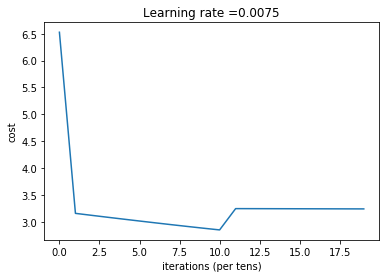

In [248]:
# ## define the network here
layer_dims = [n_x,30,n_y]

params,AL = train(X_train, Y_train, layer_dims, print_cost=True,num_iterations = 200,learning_rate=0.0075)

In [244]:
# params

In [245]:
np.argmax(AL,axis=0)

array([9, 9, 9, 9, 9], dtype=int64)

In [246]:
Y_train

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0.]])

In [247]:
AL

array([[0.09993596, 0.09993596, 0.09993596, 0.09993596, 0.09993596],
       [0.10006528, 0.10006528, 0.10006528, 0.10006528, 0.10006528],
       [0.09993596, 0.09993596, 0.09993596, 0.09993596, 0.09993596],
       [0.09992663, 0.09992663, 0.09992663, 0.09992663, 0.09992663],
       [0.10006525, 0.10006525, 0.10006525, 0.10006525, 0.10006525],
       [0.09993596, 0.09993596, 0.09993596, 0.09993596, 0.09993596],
       [0.10006529, 0.10006529, 0.10006529, 0.10006529, 0.10006529],
       [0.09993595, 0.09993595, 0.09993595, 0.09993595, 0.09993595],
       [0.09993596, 0.09993596, 0.09993596, 0.09993596, 0.09993596],
       [0.10019774, 0.10019774, 0.10019774, 0.10019774, 0.10019774]])

In [38]:
def soft(dA, cache, y):
    s ,_ = softmax(cache)
    J = - s[..., None] * s[:, None, :]
    iy, ix = np.diag_indices_from(J[0])
    J[:, iy, ix] = s * (1. - s) # diagonal
    p =  J.sum(axis=1) # sum across-rows for each sample
    print(p)
    return p

In [111]:
Y = np.array([1, 0, 0])

In [112]:
m = 3

In [62]:
z = np.array([1.8658,2.2292,2.8204])

In [113]:
AL = np.array([0.26980,0.32235,0.40784])

In [104]:
AL,_ = softmax(z)
print(AL)

[0.19857651 0.28559493 0.51582856]


In [119]:
cost = ( np.multiply(Y , np.log(AL) ) + np.multiply((1-Y) , np.log(1-AL)) ) * -1/3
print(cost)

[0.43669145 0.12970812 0.17465947]


In [97]:
dAL = -(1/m)*(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
print(dAL)

[-1.67861412  0.4665887   0.68846137]


In [122]:
np.multiply(Y , np.log10(AL))

array([-0.56895805, -0.        , -0.        ])